In [1]:
!python ../src/utils.py
%reload_ext autoreload

In [2]:
import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())

cwd: /home/bothsides/Desktop/optimizing_DEDx_estimator/notebooks


In [3]:
cluster = df.AsNumpy(["cluster_DeDxStrip"])["cluster_DeDxStrip"]
drawer = utils.HistogramDrawer()

**Input parameters I am working with now**
+ threshold
- seeds
* range fit
+ freedman_diaconis bins
- cluster
* track level h2 dedx calculator


__I should be able to return all the parameters I need to see the distribution (mpv, stddev, h2 mean) with a single parent loop__

__filter out the fits that did not converge or have pathalogical mpvs__

__check how strongly the fits tighten the mpv distributions__

In [4]:

  


# def fit_mpv(cluster: list, threshold: int, max_hists: int, verbose=False):
#   """
#   Loop over at most `max_hists` tracks with len(track)>threshold, fit a Landau,
#   and return dict of:
#     - corel   : list of (mpv, h2_mean)
#     - params  : list of (mpv, sigma)
#     - h2      : list of h2_mean
#     - neg_mpvs: list of “Event X Trk Y” with mpv<=0
#   """
  
#   # ensuring that the DEDx_IhStrip branch is on
#   tree.SetBranchStatus("DeDx_IhStrip", 1)
  
#   # pre-allocate data containers
#   corel_params   = []  # (mpv, h2_mean)
#   params  = []  # (mpv, sigma)
#   harmonic2_means= []
#   neg_ids = []
#   neg_tracks = []
  
#   # create one histogram & one TF1 and reuse them
#   hist     = rt.TH1F("h", "tmp",    1, 0, 1)     # binning/range will be reset
#   f_landau= rt.TF1("f_landau", "landau", 0, 1)
  
#   n_fits = 0
#   logs   = []  # buffer for fit printouts
  
#   for event, tracks in zip(tree, cluster):
#     for trk_idx, track in enumerate(tracks): 
#       if len(track) <= threshold:
#         continue
#       if n_fits >= max_hists:
#         break
      
#       #using precalculated track's h2 means
#       try:
#         harmonic2 = event.DeDx_IhStrip[trk_idx]
#       except (TypeError, IndexError):
#           # if it's a single float per track, omit the index
#         harmonic2 = event.DeDx_IhStrip
      
#       # Freedman–Diaconis binning
#       nbins, lo, hi = utils.freedman_diaconis_bins(track)
      
#       # reset & reconfigure the one histogram
#       hist.Reset()
#       hist.SetBins(nbins, 0, hi)
#       bw = hist.GetBinWidth(nbins)
#       hist.GetYaxis().SetTitle(f"Entries/{bw:.2f}")
      
#       # filling and drawing the hists
#       for hit in track:
#           hist.Fill(hit)
      
#       mpv_guess, amp_guess, sigma_guess = utils.seeds(hist)
      
#       f_landau.SetRange(0, hi)
#       f_landau.SetParameters(amp_guess, mpv_guess, sigma_guess) #seeding
      
#       # I'm trying to keep Minuit away from crazy regions
#       f_landau.SetParLimits(1, lo, hi)         # MPV must stay inside data
#       f_landau.SetParLimits(2, 0.05, lo - hi)  # σ positive, < full range
      
#       hist.Fit(f_landau, "RQ")
#       n_fits += 1

#       # extracting results
#       f = hist.GetFunction("f_landau")
      
#       if not f:  # fit might have failed
#         continue
      
#       mpv = f.GetParameter(1)
#       sigma = f.GetParameter(2)
      
#       corel_params.append((mpv, harmonic2))
#       params.append((mpv, sigma))
#       harmonic2_means.append(harmonic2)
      
#       if mpv <= 0:
#         neg_ids.append(f"Event {event.event} Trk {trk_idx}") 
#         neg_tracks.append(track) # capture (the actual hits of these negative)tracks
  
#       if verbose:
#           errs = [f.GetParError(i) for i in range(f.GetNpar())]
#           logs.append(f" fit#{n_fits-1}: mpv = {mpv:.3g}±{errs[1]:.3g}  sigma = {sigma:.3g}±{errs[2]:.3g} vs {harmonic2}")
   
      
      

        
#     if n_fits >= max_hists:
#       break
   
#   if verbose and logs:
#     print("\n".join(logs))
            
#   return {
#     "corel":    corel_params,
#     "params":   params,
#     "h2":       harmonic2_means,
#     "neg_mpvs": neg_ids,
#     "neg_tracks": neg_tracks
# }
      

In [5]:
import utils
print(utils.__file__)


/home/bothsides/Desktop/optimizing_DEDx_estimator/src/utils.py


In [6]:

results = utils.fit_mpv(cluster, 5, 10000)

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def

In [7]:
neg_tracks = results["neg_tracks"]
neg_track_labels = results["neg_mpvs"]


print(len(neg_tracks))

for label, track in zip(neg_track_labels, neg_tracks):
  print(f"{label} : {track}")

18
Event 36888 Trk 2 : { 2.87084f, 7.24237f, 6.13317f, 10.3733f, 18.6288f, 136.122f }
Event 37009 Trk 1 : { 3.93640f, 6.40171f, 3.93247f, 3.06810f, 3.73513f, 2.05625f, 2.60408f, 59.3439f }
Event 37077 Trk 1 : { 7.23092f, 3.21012f, 3.43804f, 99.2167f, 7.71873f, 0.972959f }
Event 37658 Trk 5 : { 3.92032f, 9.37611f, 70.5981f, 4.60633f, 2.58087f, 2.54820f, 3.98561f, 2.05819f }
Event 42271 Trk 0 : { 7.37285f, 3.14832f, 3.37351f, 82.5019f, 2.60977f, 2.95203f }
Event 42577 Trk 0 : { 7.71427f, 7.27343f, 168.580f, 12.7205f, 8.81630f, 6.51776f, 5.73063f, 7.74582f, 6.12025f, 8.00448f, 6.17840f, 6.74174f, 6.46979f, 4.83757f, 4.48795f, 6.70362f }
Event 43057 Trk 4 : { 3.15743f, 3.43331f, 4.28202f, 9.58706f, 2.82304f, 3.58343f, 2.14246f, 3.52100f, 76.7960f }
Event 43106 Trk 0 : { 2.55813f, 2.74532f, 3.77468f, 2.71405f, 4.86658f, 3.15082f, 2.68290f, 3.83715f, 3.05725f, 3.02199f, 4.60036f, 3.08001f, 63.1572f, 6.19792f, 5.65915f, 3.15677f, 2.88726f }
Event 43249 Trk 2 : { 19.8500f, 16.0639f, 7.21180f, 

In [8]:
def plot_track_distributions(tracks, labels=None):
    """
    tracks : list of sequences of hit-values
    labels : optional list of titles for each track
    bins   : histogram bin count
    """
    for i, track in enumerate(tracks):
        # Freedman–Diaconis binning
        nbins, lo, hi = utils.freedman_diaconis_bins(track)
        plt.figure()
        plt.hist(track, bins=nbins, range=(lo, hi))
        bw = (hi - lo)/nbins
        title = labels[i] if labels is not None else f"Track #{i}"
        plt.title(title)
        plt.xlabel("dE/dx")
        plt.ylabel(f"hits / {bw:.2f}")
        plt.tight_layout()
        plt.show()


In [9]:


def plot_track_distributions_pyroot(tracks, labels=None, cols=2, canvas_name="c_tracks"):
    """
    tracks      : list of sequences of hit-values
    labels      : optional list of strings, one per track
    cols        : number of columns in the canvas grid
    canvas_name : name/title for the TCanvas
    
    Returns (canvas, histo_list) where histo_list is a list of (TH1F, TF1) tuples.
    """
    N    = len(tracks)
    rows = math.ceil(N / cols)
    c    = rt.TCanvas(canvas_name, canvas_name, cols*800, rows*800)
    c.Divide(cols, rows)
    
    results = []
    for i, track in enumerate(tracks):
        pad = c.cd(i+1)
        
        # Freedman–Diaconis binning
        nbins, lo, hi = utils.freedman_diaconis_bins(track)
        title         = labels[i] if labels else f"Track {i}"
        
        # make & fill histogram
        h = rt.TH1F(f"h_{i}", title, nbins, lo, hi)
        for x in track:
            h.Fill(x)
        
        # style axes
        bw = (hi - lo) / nbins
        h.GetXaxis().SetTitle("dE/dx (MeV/cm)")
        h.GetYaxis().SetTitle(f"Entries/{bw:.2f}")
        h.SetStats(False)
        
        # draw hits
        h.Draw()
        
        # fit a Landau
        f = rt.TF1(f"f_{i}", "landau", lo, hi)
        mpv0, amp0, sig0 = utils.seeds(h)
        f.SetParameters(amp0, mpv0, sig0)
        f.SetParLimits(1, lo, hi)
        f.SetParLimits(2, 0.05, hi - lo)
        h.Fit(f, "RQ")  
        
        # draw fit on top
        f.SetLineColor(rt.kRed)
        f.Draw("same")
        
        results.append((h, f))
    
    c.Update()
    return c, results


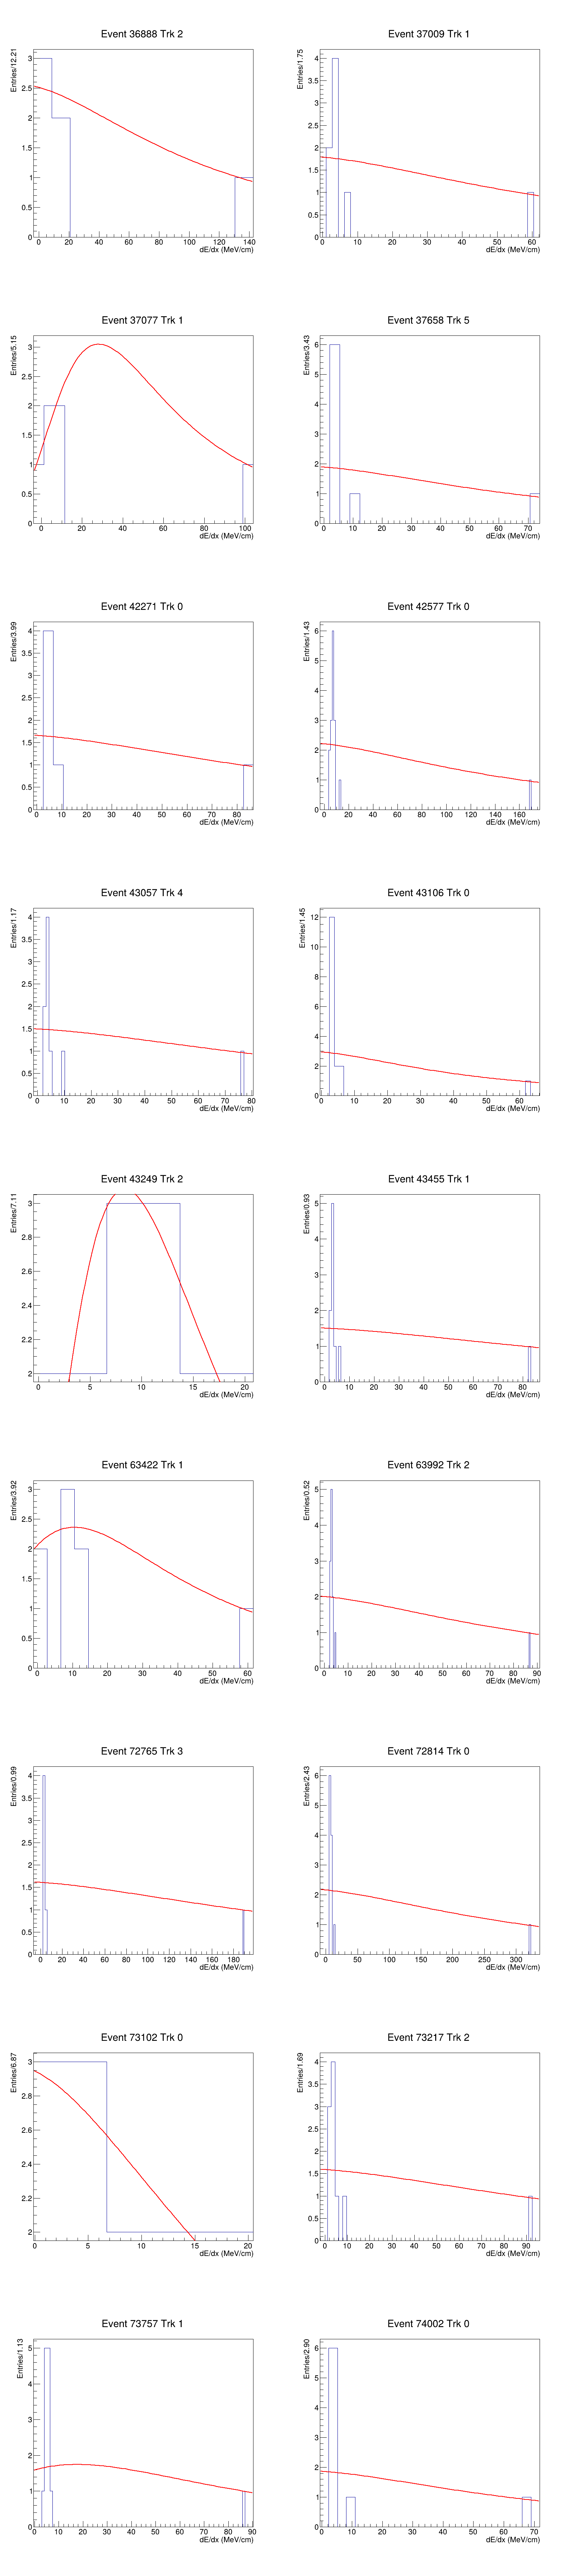

In [10]:
canvas, histo_fits = plot_track_distributions_pyroot(
    neg_tracks,
    labels=neg_track_labels,
    cols=2,
    canvas_name="c_bad_mpv_tracks",
)
canvas.Draw()

In [11]:
# drawer.save(canvas, f"{utils.PLOTS_DIR}/fitted_bad_tracks",["png"])

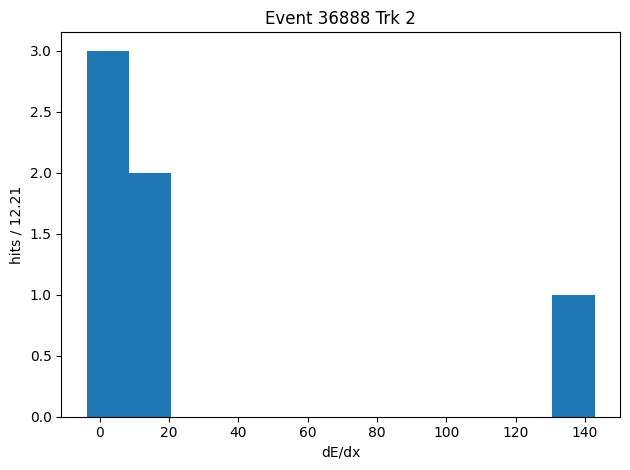

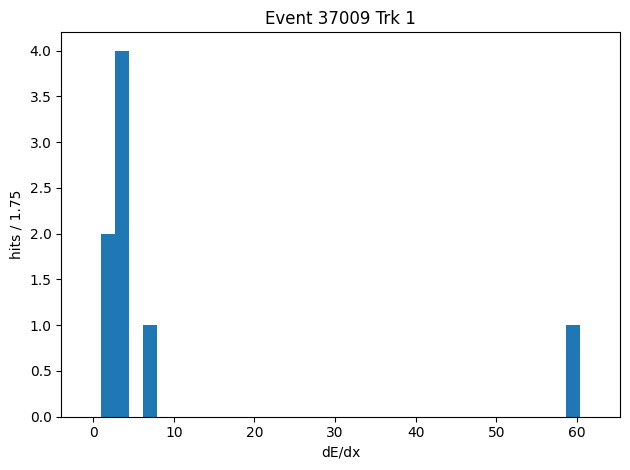

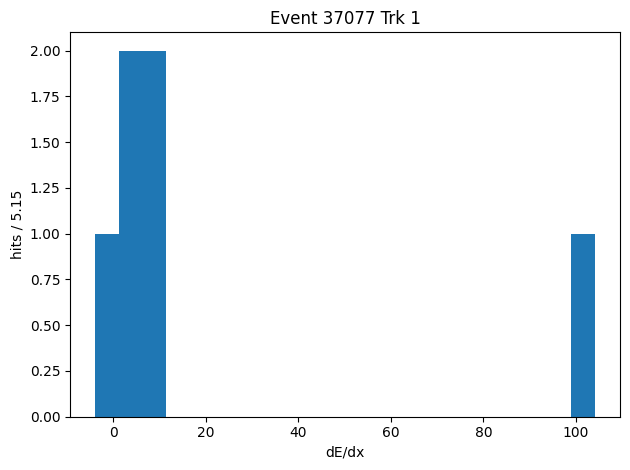

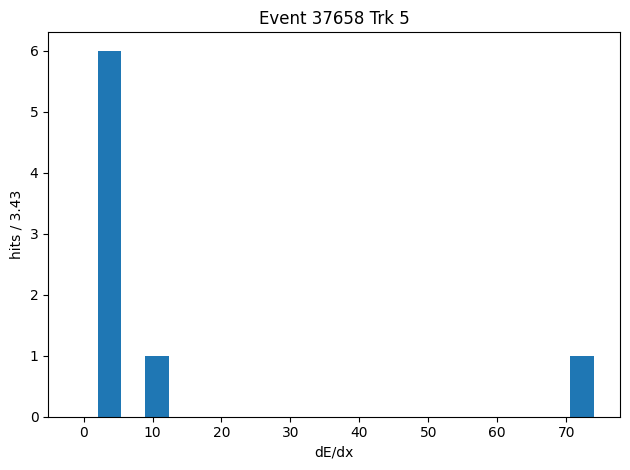

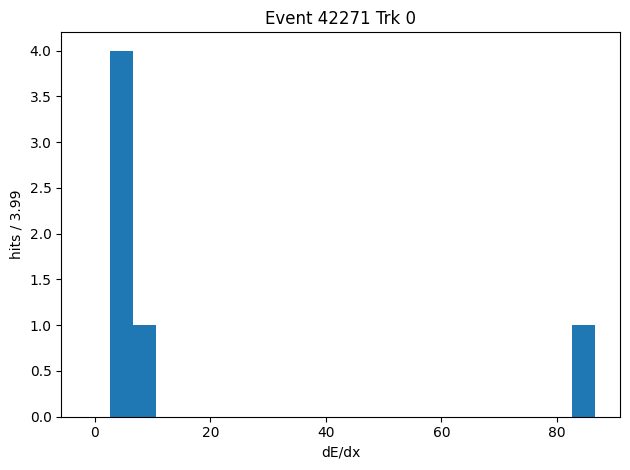

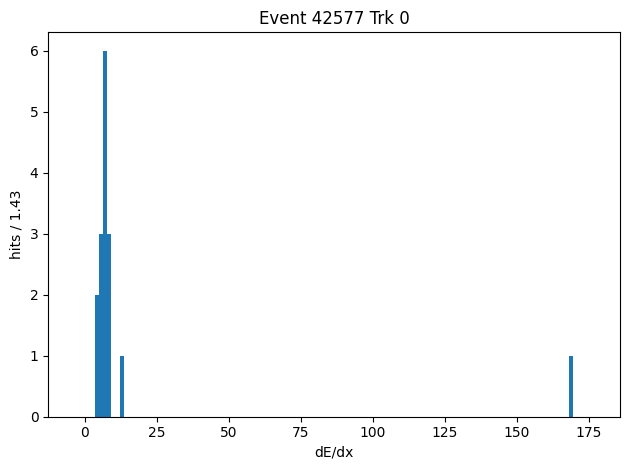

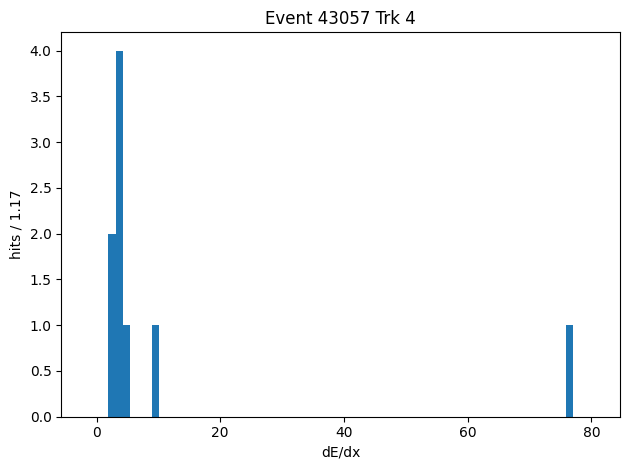

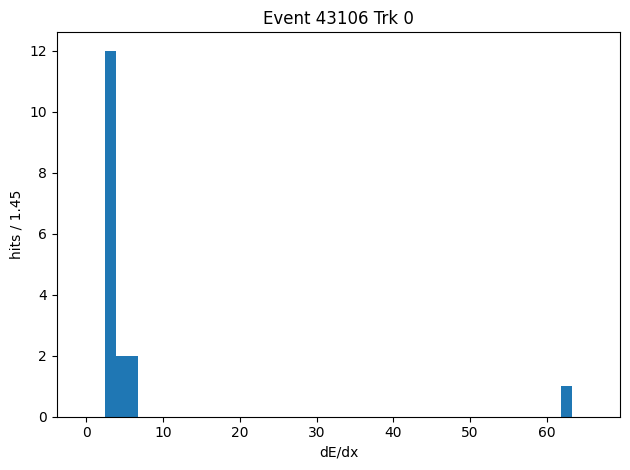

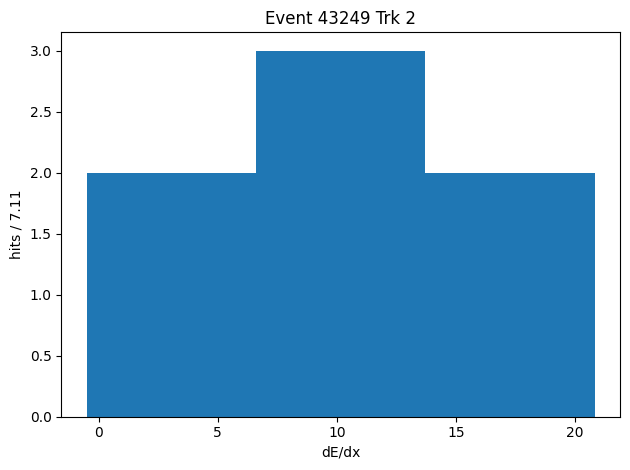

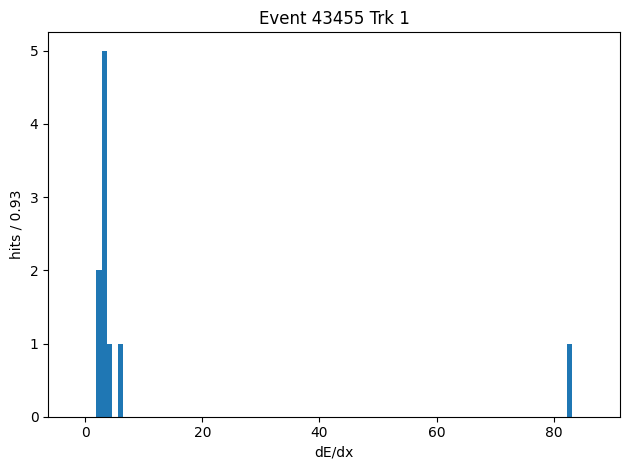

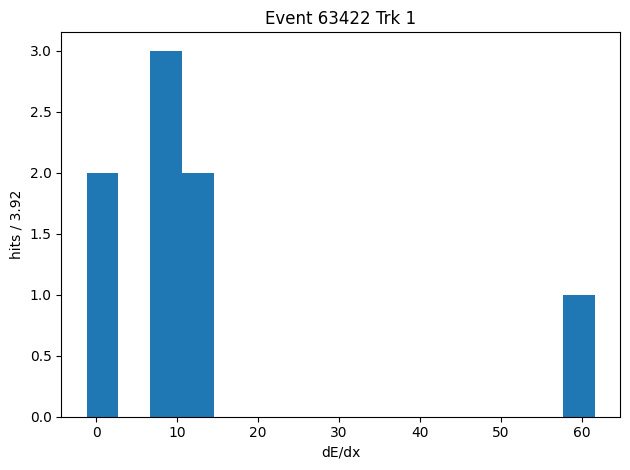

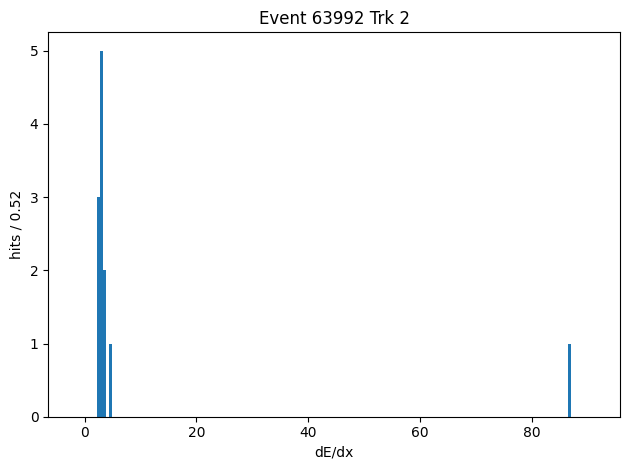

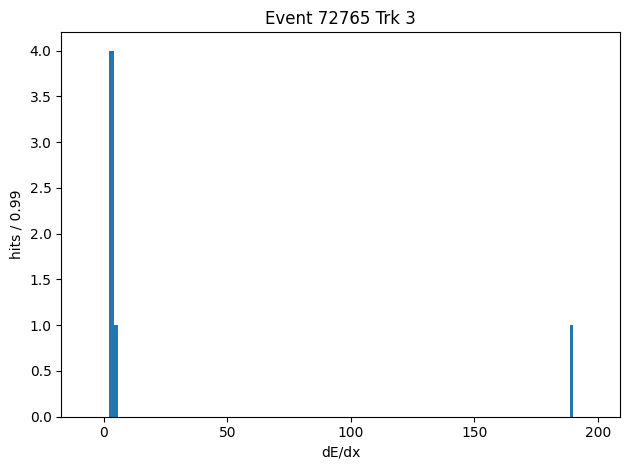

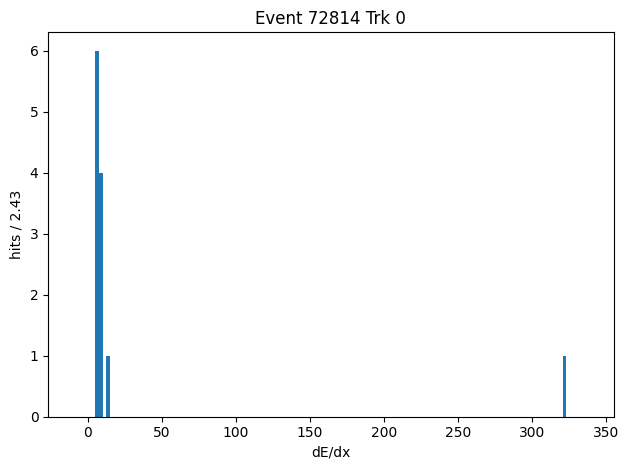

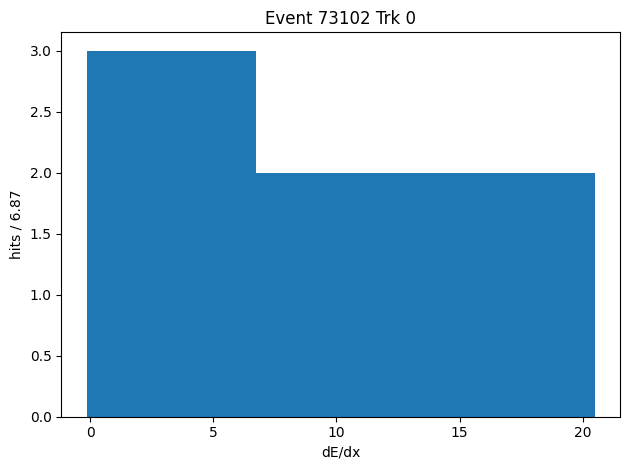

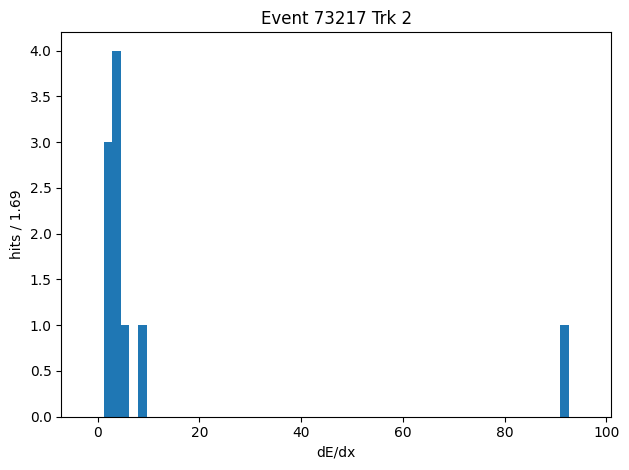

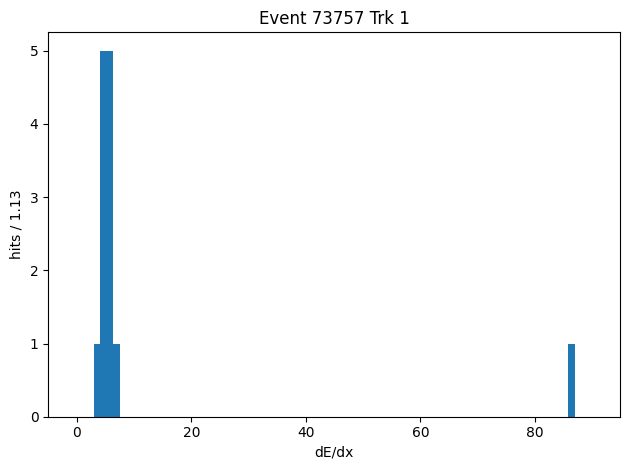

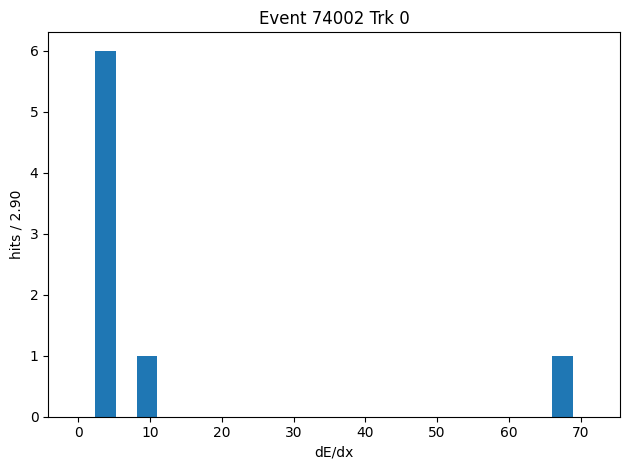

In [12]:
plot_track_distributions(neg_tracks, labels=neg_track_labels)

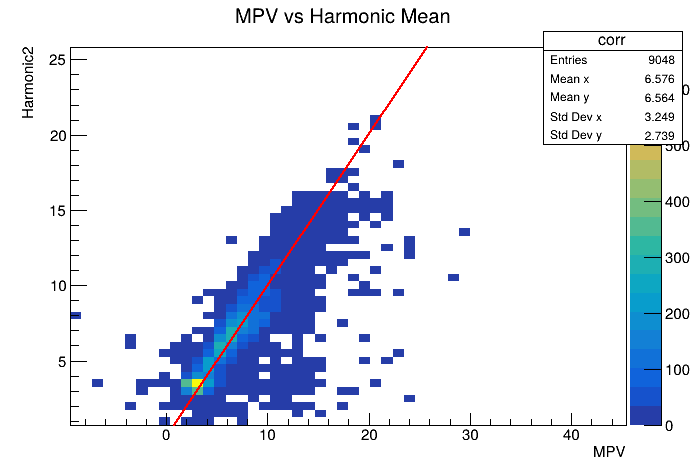

In [13]:

corel_params = results["corel"]


c = rt.TCanvas()

x_vals = [r[0] for r in corel_params]
y_vals = [r[1] for r in corel_params]
corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean;MPV;Harmonic2", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
for x, y in corel_params:
    corr_hist.Fill(x, y)
corr_hist.Draw("COLZ")


xmin, xmax = min(x_vals), max(x_vals)
ymin, ymax = min(y_vals), max(y_vals)


low  = max(xmin, ymin)
high = min(xmax, ymax)

diag = rt.TLine(low, low, high, high)   # y = x
diag.SetLineColor(rt.kRed)
diag.SetLineWidth(2)
diag.Draw("same")

c.Draw()

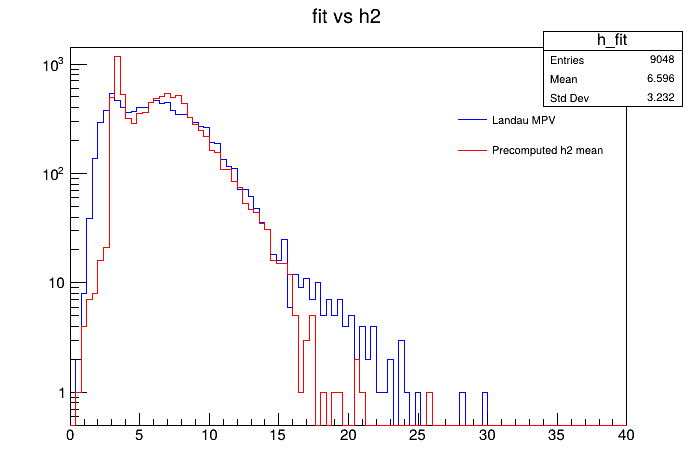

In [14]:
c = rt.TCanvas()
c.SetLogy()
# N = len(corel_params)
hist_mpv = rt.TH1F("h_fit", "fit vs h2", 100, 0, 40)
hist_h2 = rt.TH1F("h_h2", "fit vs h2",100, 0, 40)


for mpv, h2 in corel_params:
  hist_mpv.Fill(mpv)
  hist_h2.Fill(h2)

hist_mpv.SetLineColor(rt.kBlue)
hist_h2.SetLineColor(rt.kRed)
max1 = hist_mpv.GetMaximum()
max2 = hist_h2.GetMaximum()
overall_max = max(max1, max2)
hist_mpv.SetMaximum(overall_max * 1.2)

hist_mpv.Draw()
hist_h2.Draw("same")

leg = rt.TLegend(0.65, 0.65, 0.88, 0.78)  # x1,y1,x2,y2 in NDC
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hist_mpv, "Landau MPV", "l")
leg.AddEntry(hist_h2,  "Precomputed h2 mean", "l")
leg.Draw()

c.Draw()

In [15]:
# drawer.save(c, f"{utils.PLOTS_DIR}/fit_vs_h2(used_precalculated_h2_vals_logy)",["png"])

In [16]:
#generate a number of landau fit with known mpvs, use the datasets that make up the landau fits to calculate the harmonic2. check the corelation of the two 
#understand why we still get negative values
# and what makes up the outliers

In [17]:
# #TIGHTENED THE FIT RANGE AND INTRODUCED SEEDING

# thrshld = 5
# max_hists = 20000
# hist_count = 0
# # leg = rt.TLegend(0.65,0.52,0.88,0.7)

# hists = {} #dictionary to store histograms
# harmonic2_means = []
# for event, tracks in zip(tree, cluster):
# #  hists = []
#     for trk_idx, track in enumerate(tracks): 
#       if len(track) > thrshld:
#         if hist_count >= max_hists:
#           break
#         #computing harmonic2
#         harmonic2 = math.sqrt( len(track) / sum( (1.0 / (x*x)) for x in track if x > 0 ) )  #turn this into a function later on
        
#         harmonic2_means.append(harmonic2)
        
#         nbins, lo, hi = utils.freedman_diaconis_bins(track, range_pad = 0.05)
        
#         hist_name = f"fit{hist_count}"
#         title     = f"Ev {event.event}, Trk {trk_idx};dE/dx (MeV/cm);Entries"
#         hist = rt.TH1F(hist_name, title, nbins, 0, hi)
        
#         bin_width = str(round(hist.GetBinWidth(nbins), 2))
        
#         hist.GetYaxis().SetTitle("Entries/"+ bin_width)
        
#         # hist = rt.TH1F(hist_name, title, bin, 0, len(track))
#         # bin_width = hist.GetBinWidth()
#         #c = rt.TCanvas()
#         # print(len(track))
      
#         for hit in track:
#             hist.Fill(hit)
#         hist.Draw("P")
#         hist.SetMarkerStyle(20)
        
#         #trying to derive sensible seeds from each histogram
#         amp_guess  = hist.GetMaximum()                       # scale
#         mpv_guess  = hist.GetBinCenter(hist.GetMaximumBin()) # MPV
#         sigma_guess = 0.3 * hist.GetRMS() or 0.1*mpv_guess   # crude width
        
        
#         # xmin, xmax = fit_range(track, 1)
#         f_landau = rt.TF1("f_landau", "landau", 0, hi)
#         f_landau.SetParameters(amp_guess, mpv_guess, sigma_guess)   # seeds
        
#         # I'm trying to keep Minuit away from crazy regions
#         f_landau.SetParLimits(1, lo, hi)         # MPV must stay inside data
#         f_landau.SetParLimits(2, 0.05, lo - hi)  # σ positive, < full range
        
#         hist.Fit(f_landau, "RQ")
#         #c.Draw("same")
#         #print(track)
        
#         hists[hist_name] = hist # stores histograms in dict with unique key
        
#         hist_count += 1
        
#     if hist_count >= max_hists:
#         break  
  
# print("Stored histograms:", list(hists.keys()), list(hists.values()))
# print(harmonic2_means)

In [18]:
# # c = rt.TCanvas()
# stack = utils.write_stacked_histos("fits", hists, "some tracks fitted with the landau", c)

In [19]:
# fit_list = stack.GetHists()

In [20]:
# #just drawing the graphs
# N = fit_list.GetSize()

# cols = 2
# rows = math.ceil(N/cols)

# c = rt.TCanvas("c_all", "All fits", cols*800, rows*800)
# c.Divide(cols, rows)

# for i in range(N):
#   pad = c.cd(i+1)
#   fit = fit_list.At(i)
#   fit.Draw()

# c.Modified()
# c.Draw()

In [21]:
# drawer.save(c, f"{utils.PLOTS_DIR}/some ratio plots seeded, with freedman_diaconis bin width",["png"])

In [22]:
# print(len(fit_list))
# print(type(fit_list[0]))

In [23]:
# params = fit_result.GetParameter(1)
# print(params)

In [24]:
# corel_params = []      # (mpv, h2_mean)
# parameters   = []      # (mpv, sigma)
# count = 0

# for (hist_name, hist), h2_mean in zip(hists.items(), harmonic2_means):
#     f = hist.GetFunction("f_landau")
#     if not f:                          # fit might have failed
#         print(f"[skip] {hist_name}: no Landau function attached")
#         continue
#     npar = f.GetNpar()
#     params = [f.GetParameter(i) for i in range(npar)]
#     errors = [f.GetParError(i)  for i in range(npar)]
#     print(f"fit {count}")
#     count += 1
#     for i, (val, err) in enumerate(zip(params, errors)):
#         msg = f" vs {h2_mean}" if i == 1 else ""
#         print(f"par[{i}] = {val:.4g} ± {err:.4g} {msg}")
#         corel_params.append((params[1],h2_mean))
        
#     print("\n")
    
#     corel_params.append((params[1], h2_mean))
#     parameters.append((params[1], params[2]))

# # print(" (mpv, sigma):", parameters)
# # print(" (mpv, h2) :", corel_params)


In [25]:
# c = rt.TCanvas()

# x_vals = [r[0] for r in corel_params]
# y_vals = [r[1] for r in corel_params]
# corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
# for x, y in corel_params:
#     corr_hist.Fill(x, y)
# corr_hist.Draw("COLZ")


# xmin, xmax = min(x_vals), max(x_vals)
# ymin, ymax = min(y_vals), max(y_vals)


# low  = max(xmin, ymin)
# high = min(xmax, ymax)

# diag = rt.TLine(low, low, high, high)   # y = x
# diag.SetLineColor(rt.kRed)
# diag.SetLineWidth(2)
# diag.Draw("same")

# c.Draw()

In [26]:
# import ROOT as rt
# import math, numpy as np

# thrshld    = 10          # min strip hits per track
# max_hists  = 5000        # safety cap (optional)

# mpv_h2_pairs = []        # final flat list of (MPV, harmonic-2)

# hist_count   = 0
# hists_good   = {}        # keep only successfully-fitted histos

# for event, tracks in zip(tree, cluster):               # cluster parallels tree
#     for trk_idx, track in enumerate(tracks):

#         if len(track) <= thrshld:
#             continue

#         # ---------- build & fill histogram
#         hist_name = f"trkFit{hist_count}"
#         hist      = rt.TH1F(hist_name, "dE/dx per strip", len(track), 0, len(track))
#         for hit in track:
#             hist.Fill(hit)

#         if hist.GetEntries() < 6:          # too little data ⇒ skip
#             continue

#         # ---------- Landau fit
#         fit_ptr = hist.Fit("landau", "QS0")      # Q=quiet, S=return result, 0=no-draw
#         if not fit_ptr or fit_ptr.Status() != 0: # fit did not converge → skip
#             hist_count += 1
#             continue

#         # ---------- extract MPV from the fit
#         landau_f = hist.GetFunction("landau")
#         mpv      = landau_f.GetParameter(1)      # Most-probable value

#         # ---------- compute harmonic-2 ( Ih )
#         h2 = math.sqrt(len(track) /
#                        sum((1.0 / (x*x)) for x in track if x > 0))

#         # ---------- store results
#         mpv_h2_pairs.append((mpv, h2))
#         hists_good[hist_name] = hist
#         hist_count += 1

#         if hist_count >= max_hists:
#             break
#     if hist_count >= max_hists:
#         break

# # ------------- flat NumPy array if you like
# mpv_h2_np = np.array(mpv_h2_pairs, dtype=np.float64)   # shape (N, 2)

# print(f"Kept {len(mpv_h2_pairs)} fitted tracks out of {hist_count} candidates")
# print("First five (MPV, harmonic-2) pairs:\n", mpv_h2_pairs[:5])
